In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/ankurgupta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# get the data
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [21]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    n=-1
    
    for line in open(filname):
        n+=1
        if n<10001:
            if first:
                first = False
            else:
                row = line.split(',')
                Y.append(int(row[0]))
                X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [22]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [23]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
X_train.shape

(9000, 48, 48, 1)

In [25]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [26]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 128)       512       
__________

In [37]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=15, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 1248s 139ms/step - loss: 1.8515 - acc: 0.2738 - val_loss: 1.9824 - val_acc: 0.1730
Epoch 2/15
9000/9000 [==============================] - 1265s 141ms/step - loss: 1.6541 - acc: 0.3590 - val_loss: 1.8332 - val_acc: 0.3520
Epoch 3/15
9000/9000 [==============================] - 2701s 300ms/step - loss: 1.5169 - acc: 0.4151 - val_loss: 1.6605 - val_acc: 0.3290
Epoch 4/15
9000/9000 [==============================] - 1007s 112ms/step - loss: 1.3888 - acc: 0.4756 - val_loss: 1.5868 - val_acc: 0.3990
Epoch 5/15
9000/9000 [==============================] - 1063s 118ms/step - loss: 1.2547 - acc: 0.5234 - val_loss: 1.9686 - val_acc: 0.3460
Epoch 6/15
9000/9000 [==============================] - 6209s 690ms/step - loss: 1.1157 - acc: 0.5802 - val_loss: 1.4831 - val_acc: 0.4680
Epoch 7/15
9000/9000 [==============================] - 1064s 118ms/step - loss: 0.9676 - acc: 0.6428 - val_loss: 1.67

In [40]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

/Users/ankurgupta/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


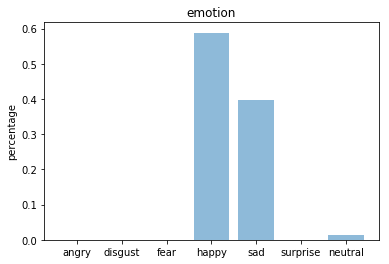

In [44]:
from skimage import io
img = image.load_img('output-onlinepngtools.png', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

emotion_analysis(custom[0])

# x = np.array(x, 'float32')
# x = x.reshape([48, 48]);

# plt.gray()
# plt.imshow(x)
# plt.show()